# Theoratical Aspects

- Regularizaton reduces the overall complexity of the machine learning model by reducing the complexity of the weights

- Helpers neural network generalize the problem
- One aspect is feature selection which allows to remove irrelevant features which are not helpful
- When talking about correlation, we are only concerned with either positive or negative values, the values in between do not give much information about the feature relations with the target attribute


### L1 (LASSO)
- When we apply L1 regularization to linear regression it is called LASSO
- Compute the absolute sum of the weights and multiple it by a factor called aplha, the value should be kept moderate and it is a hyper parameter.
- Used for feature selection, gets rid of inputs that are not valuable
- Brings down coefficients


### L2 (Ridge)
- Takes the square of the values of the weights
- Does not support ruling out the weights all together, instead it is softer than L!



### When to use L1 vs L2
- If you have large number of irrelevant inputs, run L1 to rule most of them out, importance ranking




- Kernel ---> adds the regularizer on the weights
- Activity ---> add the regularizer on the output



### Dropouts
- Prevents overfitting of neural networks
- Removes neurons during training
- Specify a percentage to be dropped out at each epoch
- Prevents overfitting in such a way that we do not allow neurons to specialize in a certain tasks rather drop neurons so that other neurons can train better and generalize
- Dropout layers can be added in between any two layers


# Helper Methods

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os
import requests
import base64


# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the original column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df, name, target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x) == str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name, tv)
        df[name2] = l


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low
        
# This function submits an assignment.  You can submit an assignment as much as you like, only the final
# submission counts.  The paramaters are as follows:
# data - Pandas dataframe output.
# key - Your student key that was emailed to you.
# no - The assignment class number, should be 1 through 1.
# source_file - The full path to your Python or IPYNB file.  This must have "_class1" as part of its name.  
# .             The number must match your assignment number.  For example "_class2" for class assignment #2.
def submit(data,key,no,source_file=None):
    if source_file is None and '__file__' not in globals(): raise Exception('Must specify a filename when a Jupyter notebook.')
    if source_file is None: source_file = __file__
    suffix = '_class{}'.format(no)
    if suffix not in source_file: raise Exception('{} must be part of the filename.'.format(suffix))
    with open(source_file, "rb") as image_file:
        encoded_python = base64.b64encode(image_file.read()).decode('ascii')
    ext = os.path.splitext(source_file)[-1].lower()
    if ext not in ['.ipynb','.py']: raise Exception("Source file is {} must be .py or .ipynb".format(ext))
    r = requests.post("https://api.heatonresearch.com/assignment-submit",
        headers={'x-api-key':key}, json={'csv':base64.b64encode(data.to_csv(index=False).encode('ascii')).decode("ascii"),
        'assignment': no, 'ext':ext, 'py':encoded_python})
    if r.status_code == 200:
        print("Success: {}".format(r.text))
    else: print("Failure: {}".format(r.text))

In [2]:
from sklearn.linear_model import LassoCV
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split 

path = os.getcwd() + "/Assignments/data"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
# Do not need zscore standardization for linear regression
#encode_numeric_zscore(df, 'horsepower')
#encode_numeric_zscore(df, 'weight')
#encode_numeric_zscore(df, 'cylinders')
#encode_numeric_zscore(df, 'displacement')
#encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)

/Users/wajih_siddiqui/.virtualenvs/deep-learning/lib/python2.7/site-packages/ipykernel_launcher.py:76: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [3]:
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))

# Without Regularization

Final score (RMSE): 2.93715667725


,coef,positive
origin-1,-1.448374,False
cylinders,-0.416544,False
horsepower,-0.007785,False
weight,-0.007473,False
displacement,0.024456,True
acceleration,0.138122,True
origin-3,0.629809,True
year,0.801274,True
origin-2,0.818565,True


Intercept: [-18.257536]


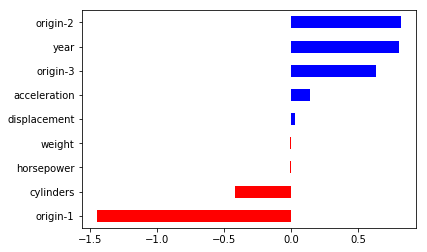

In [4]:
import sklearn

# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)

# With L1 Regularization

Final score (RMSE): 3.04090595245


,coef,positive
origin-1,-1.264473,False
weight,-0.007458,False
horsepower,-0.002797,False
cylinders,-0.000000,True
origin-2,0.000000,True
origin-3,0.000000,True
displacement,0.013005,True
acceleration,0.113760,True
year,0.787195,True


Intercept: [-17.271269]
Irrelevant features automatically ruled out


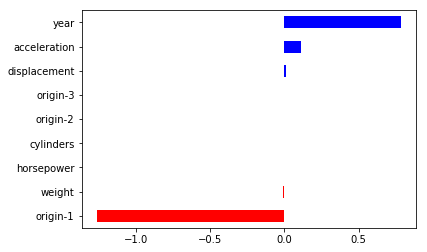

In [5]:
import sklearn
from sklearn.linear_model import Lasso

# Create linear regression
regressor = Lasso(random_state=0,alpha=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)



print "Irrelevant features automatically ruled out"

# Trying out multiple values of Alpha

/Users/wajih_siddiqui/.virtualenvs/deep-learning/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(1e-08, 100000000.0)

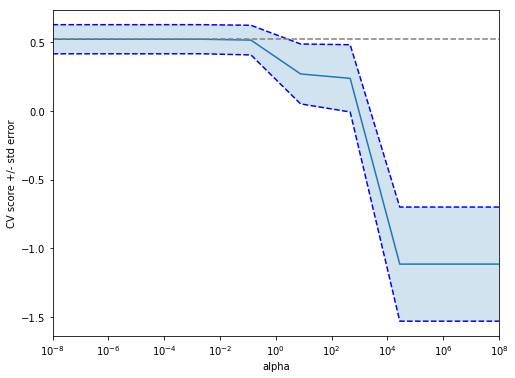

In [6]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

lasso = Lasso(random_state=42)
alphas = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, x, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# With L2 Regularization

Final score (RMSE): 2.94131350517


/Users/wajih_siddiqui/.virtualenvs/deep-learning/lib/python2.7/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.879744e-09
  overwrite_a=True).T


,coef,positive
origin-1,-1.420945,False
cylinders,-0.409650,False
horsepower,-0.007524,False
weight,-0.007473,False
displacement,0.024127,True
acceleration,0.137980,True
origin-3,0.619065,True
year,0.800767,True
origin-2,0.801773,True


Intercept: [-18.23039]


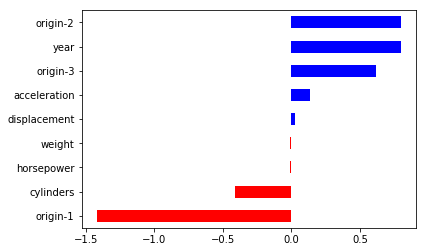

In [7]:
import sklearn
from sklearn.linear_model import Ridge

# Create linear regression
regressor = Ridge(alpha=1)

# Fit/train Ridge
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)

Final score (RMSE): 3.03198480606


,coef,positive
origin-1,-0.938925,False
cylinders,-0.257569,False
weight,-0.007462,False
horsepower,-0.002896,False
displacement,0.017533,True
acceleration,0.131320,True
origin-3,0.369088,True
origin-2,0.458725,True
year,0.788913,True


Intercept: [-17.480112]


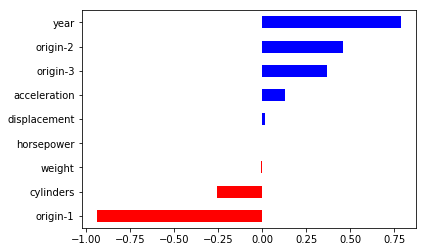

In [8]:
import sklearn
from sklearn.linear_model import ElasticNet

# Create linear regression
regressor = ElasticNet(alpha=0.1, l1_ratio=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

# Using L1 & L2 with TensorFlow

In [13]:
########################################
# TensorFlow with L1/L2 for Regression
########################################
%matplotlib inline
from matplotlib.pyplot import figure, show
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.models import Sequential

path = os.getcwd() + "/Assignments/data"

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
x,y = to_xy(df,"mpg")
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)

model = Sequential()
model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(10, 
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01),activation='relu'))
# activity_regularizer can also be used.
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=500)
pred = model.predict(x_test)
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

/Users/wajih_siddiqui/.virtualenvs/deep-learning/lib/python2.7/site-packages/ipykernel_launcher.py:76: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch 00046: early stopping
Final score (RMSE): 3.66381406784


# Dropout

In [14]:
############################################
# TensorFlow with Dropout for Regression
############################################
%matplotlib inline
from matplotlib.pyplot import figure, show
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.models import Sequential

# path = "./data/"

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

df.drop('name',1,inplace=True)
missing_median(df, 'horsepower')
x,y = to_xy(df,"mpg")
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45)

model = Sequential()
model.add(Dense(50, input_dim=x.shape[1]))
model.add(Dropout(0.01))
model.add(Dense(25, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor],verbose=0,epochs=1000)
pred = model.predict(x_test)
# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

/Users/wajih_siddiqui/.virtualenvs/deep-learning/lib/python2.7/site-packages/ipykernel_launcher.py:76: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Epoch 00262: early stopping
Final score (RMSE): 4.85369586945
